- python 2.7  
- cv2 3.4

In [1]:
import numpy as np
import cv2
from cv2 import aruco
import pickle
import glob
import math
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl
# import pandas as pd
# %matplotlib nbagg
%matplotlib inline

In [2]:
def save_img(name, img):
    file_name = os.path.join("output/test", name)
    cv2.imwrite(file_name, img)

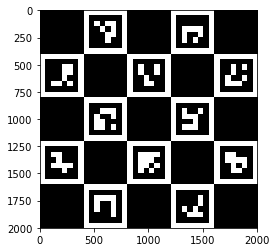

In [3]:
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_4X4_250)
CHARUCO_BOARD = aruco.CharucoBoard_create(
        squaresX=5,
        squaresY=5,
        squareLength=0.02,
        markerLength=0.015,
        dictionary=ARUCO_DICT)
type(CHARUCO_BOARD)
imboard = CHARUCO_BOARD.draw((2000, 2000))

save_img("CHARUCO_BOARD.png", imboard)

# # cv2.imwrite(workdir + "chessboard.tiff", imboard)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
# ax.axis("off")
plt.show()

In [4]:
# # Create the arrays and variables we'll use to store info like corners and IDs from images processed
# corners_all = [] # Corners discovered in all images processed
# ids_all = [] # Aruco ids corresponding to corners discovered
# image_size = None # Determined at runtime
# imgs=[]

# # This requires a set of images or a video taken with the camera you want to calibrate
# # All images used should be the same size, which if taken with the same camera shouldn't be a problem
# images = glob.glob('picture/0720/*.jpg')
# print(len(images))

In [5]:
def get_images_corners_and_ids(images_dir_list):
    corners_all = [] # Corners discovered in all images processed
    ids_all = [] # Aruco ids corresponding to corners discovered
    image_size = None
    
    for iname in images_dir_list:
        img = cv2.imread(iname)
        # Grayscale the image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find aruco markers in the query image
        corners, ids, _ = aruco.detectMarkers(
                image=gray,
                dictionary=ARUCO_DICT)
        
        if len(corners) > 10:
        # Outline the aruco markers found in our query image
            img = aruco.drawDetectedMarkers(
                    image=img, 
                    corners=corners)  

            # Get charuco corners and ids from detected aruco markers
            response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                    markerCorners=corners,
                    markerIds=ids,
                    image=gray,
                    board=CHARUCO_BOARD)
            
            # Add these corners and ids to our calibration arrays
            corners_all.append(charuco_corners)
            ids_all.append(charuco_ids)
        # If our image size is unknown, set it now
    if not image_size:
        image_size = gray.shape[::-1]   
               
    return corners_all, ids_all, image_size

def get_cam_matrix(images_path='picture/0720/*.jpg', save_calibration_dir="./"):
    # -----------------------------------------------
    # input images directory
    images_dir_list = glob.glob(images_path)
    # -----------------------------------------------
    # get images corners and ids 
    corners_all, ids_all, image_size = get_images_corners_and_ids(images_dir_list)
    # -----------------------------------------------
    # get cameraMatrix and distCoeffs
    calibration, cameraMatrix, distCoeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_all,
        charucoIds=ids_all,
        board=CHARUCO_BOARD,
        imageSize=image_size,
        cameraMatrix=None,
        distCoeffs=None)
    # -----------------------------------------------
    # save cameraMatrix and distCoeffs
    f = open('{}/calibration.pckl'.format(save_calibration_dir), 'wb')
    pickle.dump((cameraMatrix, distCoeffs), f)
    f.close()
    
    
    return cameraMatrix, distCoeffs, calibration
    


# cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path='picture/0720/*.jpg')

In [6]:
def AngleAxis2EulerZYX(rvec):
    
    R=cv2.Rodrigues(rvec)
    return Mat2Euler(R[0])

def Mat2Euler(_R):
#     sy = math.sqrt(_R.at<double>(0,0) * _R.at<double>(0,0) +  _R.at<double>(1,0) * _R.at<double>(1,0) );
#     sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[0,1] * _R[0,1] );
    sy = math.sqrt(_R[0,0] * _R[0,0] +  _R[1,0] * _R[1,0] );
    if (sy < 1e-6): # If
        singular=True
    else:
        singular=False
#     float x, y, z;
    if (not singular):
#         x = atan2(_R.at<double>(2,1) , _R.at<double>(2,2));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = atan2(_R.at<double>(1,0), _R.at<double>(0,0));
#         x = math.atan2(_R[1,2] , _R[2,2]);
#         y = math.atan2(-_R[0,2], sy);
#         z = math.atan2(_R[0,1], _R[0,0]);
        x = math.atan2(_R[2,1] , _R[2,2]);
        y = math.atan2(-_R[2,0], sy);
        z = math.atan2(_R[1,0], _R[0,0]);
    else:
#         x = atan2(-_R.at<double>(1,2), _R.at<double>(1,1));
#         y = atan2(-_R.at<double>(2,0), sy);
#         z = 0;
#         x = math.atan2(-_R[2,1], _R[1,1]);
#         y = math.atan2(-_R[0,2], sy);
#         z = 0;
        x = math.atan2(-_R[1,2], _R[1,1]);
        y = math.atan2(-_R[2,0], sy);
        z = 0;
    
    return [x, y, z]

In [7]:
def get_rvec2_and_tvec2(image, cameraMatrix, distCoeffs):
    # Grayscale the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find aruco markers in the query image
    corners, ids, _ = aruco.detectMarkers(
            image=gray,
            dictionary=ARUCO_DICT)
    
    is_detected = False
    if len(corners) > 10:
        is_detected = True
        # Get charuco corners and ids from detected aruco markers
        response, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
                markerCorners=corners,
                markerIds=ids,
                image=gray,
                board=CHARUCO_BOARD)

        ret2, rvec2, tvec2 = aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, CHARUCO_BOARD, cameraMatrix, distCoeffs)
    else:
        rvec2 = tvec2 = None
    return rvec2, tvec2, is_detected

def shift_coordinate(rvec2, tvec2):
    Euler = AngleAxis2EulerZYX(rvec2)
    tx = (CHARUCO_BOARD.getChessboardSize()[0]) * (CHARUCO_BOARD.getSquareLength())/2
    ty = (CHARUCO_BOARD.getChessboardSize()[1]) * (CHARUCO_BOARD.getSquareLength())/2
    # TransO = (Mat_<double>(3,1) <<tx,ty,0);
    TransO = np.array([tx,ty,0])

    R=cv2.Rodrigues(rvec2)
    Trans_tvec = R[0].dot(TransO)
    CharucoPose=[0,0,0,0,0,0]
    for j in range(3):
        tvec2[j]+=Trans_tvec[j]
    #     tvec[i]=tvec[i]+Trans_tvec.at<double>(i,0)
        CharucoPose[j]  = tvec2[j][0]*1000
        CharucoPose[j+3]= Euler[j]*180/math.pi
    return rvec2, tvec2

def draw_coordinate(image, cameraMatrix, distCoeffs, rvec2, tvec2):

    return aruco.drawAxis(image,cameraMatrix,distCoeffs,rvec2,tvec2,0.1)

In [8]:
def accel_data(accel):
    return np.asarray([accel.x, accel.y, accel.z])

In [9]:
def check_elements_in_range(array, target, tolerance=0.05):
    """
    检查数组中的元素是否在给定的范围内。

    参数:
    array (np.ndarray): 要检查的Numpy数组。
    tolerance (float): 容差值，用于定义范围。

    返回:
    tuple: (all_in_range, any_in_range)
        - all_in_range (bool): 数组中的所有元素是否都在范围内。
        - any_in_range (bool): 数组中是否至少有一个元素在范围内。
    """
    big = target + tolerance
    small = target - tolerance
    
    mask = (small < array) & (array < big)
        
    return mask.all()

def write_text_on_image(image, list_a_r_t, list_a_r_t_saved, org=(50, 50), tolerance=0.05, is_white=False):    

    # 定义多行文字
    lines_of_text = [
        "accel: {}".format(str([round(x, 3) for x in list_a_r_t[0]])),
        "rvec2: {}".format(str([round(x, 3) for x in list_a_r_t[1]])),
        "tvec2: {}".format(str([round(x, 3) for x in list_a_r_t[2]])),
    ]
    # 定义初始位置（左下角）
    org = org
    
    # 定义字体
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # 定义字体大小
    font_scale = 1
    
    # 定义背景颜色（BGR格式）
    bg_color = (0, 0, 0)  # 黑色
    
    # 定义字体厚度
    thickness = 2
    
    # 定义行间距
    line_spacing = 15

    # 在图片上添加多行带背景色的文字
    for i, line in enumerate(lines_of_text):
        # 计算文字大小
        (text_width, text_height), baseline = cv2.getTextSize(line, font, font_scale, thickness)
        
        # 计算每行文字的位置
        x, y = org[0], org[1] + i * (text_height + line_spacing)
        
        # 绘制背景矩形
        cv2.rectangle(image, (x, y - text_height - baseline), (x + text_width, y + baseline), bg_color, -1)
        
        # 在背景矩形上绘制文字
        is_all_true = check_elements_in_range(list_a_r_t[i], list_a_r_t_saved[i], tolerance=0.05)

        text_color = (0, 255, 0) if is_all_true else (255, 255, 255)
        text_color = (255, 255, 255) if is_white else text_color

        cv2.putText(image, line, (x, y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    
    return image

__name__ == __main__

In [10]:
try:

    # 打開並讀取保存的校準數據文件
    with open('calibration.pckl', 'rb') as f:
        cameraMatrix, distCoeffs = pickle.load(f)
except:
    cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path=r'C:\Users\NEAF\code\yen\take_photo\images\Jun12_H15_M29_S58\*_color.jpg')
    # cameraMatrix, distCoeffs, calibration = get_cam_matrix(images_path='picture/0720/*.jpg')

print(cameraMatrix, distCoeffs)


# # ------------------------------------------------------------------------
# # test cameraMatrix and distCoeffs
# images = glob.glob(r'C:\Users\NEAF\code\yen\take_photo\images\Jun12_H15_M29_S58\*_color.jpg')

# print("images amount", len(images))
# for image_dir in images:
#     image = cv2.imread(image_dir)
#     basename = os.path.basename(image_dir)

#     rvec2, tvec2, is_detected = get_rvec2_and_tvec2(image, cameraMatrix, distCoeffs)
#     print("--------------image--------------")
#     print(basename)
#     # print(rvec2, tvec2)
#     # rvec2, tvec2 = shift_coordinate(rvec2, tvec2)
#     if is_detected:
#         image_drawed = draw_coordinate(image, cameraMatrix, distCoeffs, rvec2, tvec2)
#     else:
#         image_drawed = image
    
#     plt.imshow(cv2.cvtColor(image_drawed, cv2.COLOR_RGB2BGR))
#     plt.show()
# # ------------------------------------------------------------------------

(array([[644.90816367,   0.        , 653.27325863],
       [  0.        , 645.00275109, 370.4356011 ],
       [  0.        ,   0.        ,   1.        ]]), array([[-5.49494408e-02,  1.02316868e-01,  2.12808300e-05,
        -4.05257344e-04, -9.24564232e-02]]))


In [12]:
import pyrealsense2 as rs
import numpy as np
import cv2
from datetime import datetime
import os

p = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
# config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
# config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
p.start(config)

imu_p = rs.pipeline()
imu_config = rs.config()
imu_config.enable_stream(rs.stream.accel)
imu_p.start(imu_config)

# path
current_time = datetime.now().strftime("%b%d_H%H_M%M_S%S")

try:
    while True:
        frames = p.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = cv2.flip(depth_image, -1)
        color_image = cv2.flip(color_image, -1)

        imu_frames = imu_p.wait_for_frames()
        accel = accel_data(imu_frames[0].as_motion_frame().get_motion_data())

        try:
            # color image add coordination
            rvec2, tvec2, is_detected = get_rvec2_and_tvec2(color_image, cameraMatrix, distCoeffs)
            color_image = draw_coordinate(color_image, cameraMatrix, distCoeffs, rvec2, tvec2)

            with open('acc_rot_tran.pckl', 'rb') as f:
                accel__, rvec2__, tvec2__ = pickle.load(f)

            list_a_r_t = [accel, rvec2, tvec2]
            list_a_r_t_saved = [accel__, rvec2__, tvec2__]      
        
            color_image = write_text_on_image(color_image, list_a_r_t, list_a_r_t_saved, org=(50, 50), tolerance=0.05)         
            color_image = write_text_on_image(color_image, list_a_r_t_saved, list_a_r_t_saved, org=(700, 50), is_white=True)       


        except:
            pass            
            
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        images = np.hstack((color_image, depth_colormap))

        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', color_image)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
        elif key & 0xFF == ord('s'):
            f = open('acc_rot_tran.pckl', 'wb')
            pickle.dump((accel, rvec2, tvec2), f)
            f.close()            

finally:
    p.stop()
    imu_p.stop()